In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2024-07-09 18:21:23.506808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 18:21:23.506871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 18:21:23.508368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preparing The Data

In [2]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("/kaggle/input/dataset/data/train") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [3]:
test_data = pathlib.Path("/kaggle/input/dataset/data/test") # turn our training path into a Python path

In [4]:
print(data_dir)

/kaggle/input/dataset/data/train


In [5]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (48, 48)


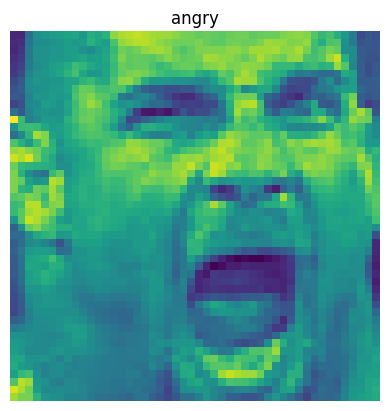

In [6]:
# View a random image from the training dataset
img = view_random_image(target_dir="/kaggle/input/dataset/data/train/",
                        target_class="angry")

In [7]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


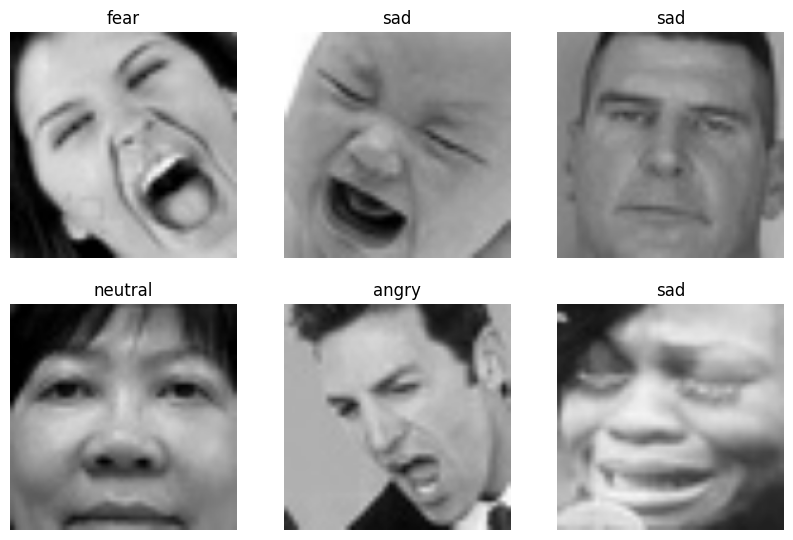

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Training The Model


In [22]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(48,48,3),
                   pooling='avg',classes=7,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

x = resnet_model
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x) 
#resnet = Model(inputs=resnet_model.input, outputs=predictions)
#resnet_model.add(pretrained_model)
#resnet_model.add(keras.layers.Flatten())
#resnet_model.add(keras.layers.Dense(512, activation='relu'))
#resnet_model.add(keras.layers.Dense(7, activation='softmax'))

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <Sequential name=sequential_5, built=False> (of type <class 'keras.src.models.sequential.Sequential'>)

In [18]:
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # Adjust the number of classes as per your dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 186, 186,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 90, 90,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 90, 90,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 90, 90,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 92, 92,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 45, 45,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 45, 45,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 45, 45,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 45, 45,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 45, 45,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 45, 45,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 45, 45,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 45, 45,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 45, 45,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 45, 45,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 45, 45,    │      1,024 │ conv2_block1_3_c

 Total params: 25,693,063 (98.01 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 7)

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the ResNet50 model with pre-trained weights, excluding the top (output) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # Adjust the number of classes as per your dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(data_dir, target_size=(180, 180), batch_size=32, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(test_data, target_size=(180, 180), batch_size=32, class_mode='categorical')

# Train the model
model.fit(train_generator, epochs=5, validation_data=validation_generator)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/898 ━━━━━━━━━━━━━━━━━━━━ 3:49:59 15s/step - accuracy: 0.1875 - loss: 2.0388

I0000 00:00:1720549357.119300     197 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


898/898 ━━━━━━━━━━━━━━━━━━━━ 348s 371ms/step - accuracy: 0.2182 - loss: 1.8738 - val_accuracy: 0.2540 - val_loss: 1.7970
Epoch 2/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 261s 288ms/step - accuracy: 0.2520 - loss: 1.7975 - val_accuracy: 0.2604 - val_loss: 1.7870
Epoch 3/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 266s 294ms/step - accuracy: 0.2551 - loss: 1.7885 - val_accuracy: 0.2558 - val_loss: 1.7779
Epoch 4/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 263s 290ms/step - accuracy: 0.2522 - loss: 1.7859 - val_accuracy: 0.2636 - val_loss: 1.7691
Epoch 5/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 265s 293ms/step - accuracy: 0.2595 - loss: 1.7816 - val_accuracy: 0.2704 - val_loss: 1.7569


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

keras_tuner.applications.HyperEfficientNet(
    input_shape=None, input_tensor=None, classes=7, augmentation_model=None, **kwargs
)
# Load the ResNet50 model with pre-trained weights, excluding the top (output) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = BatchNormalization()(x)  # Add batch normalization
x = Dense(1024, activation='relu')(x)  # Add a dense layer
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(512, activation='relu')(x)  # Add another dense layer
predictions = Dense(7, activation='softmax')(x)  # Final output layer (adjust number of classes as needed)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset/data/train', target_size=(180, 180), batch_size=32, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('/kaggle/input/dataset/data/test', target_size=(180, 180), batch_size=32, class_mode='categorical')

# Train the model
model.fit(train_generator, epochs=5, validation_data=validation_generator)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 293s 310ms/step - accuracy: 0.2622 - loss: 1.8666 - val_accuracy: 0.3327 - val_loss: 1.6686
Epoch 2/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 264s 291ms/step - accuracy: 0.3242 - loss: 1.6971 - val_accuracy: 0.3665 - val_loss: 1.6056
Epoch 3/5
703/898 ━━━━━━━━━━━━━━━━━━━━ 55s 283ms/step - accuracy: 0.3421 - loss: 1.6532

KeyboardInterrupt: 

# Evaluating The Model

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [ ]:
import cv2
image=cv2.imread(str(roses[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)


In [ ]:
pred=resnet_model.predict(image)
print(pred)

In [ ]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

In [25]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [26]:
train_path = '/kaggle/input/dataset/data/train'
test_path = '/kaggle/input/dataset/data/test'

In [28]:
IMAGE_SIZE =[180, 180]

In [46]:
from tensorflow.keras.applications import MobileNet

In [47]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

/tmp/ipykernel_128/1047624427.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(180, 180, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
for layer in base_model.layers:
    layer.trainable = False

In [49]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = Dense(512, activation='relu')(x)  # Add another dense layer
predictions = Dense(7, activation='softmax')(x) 

In [50]:
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset/data/train', target_size=(180, 180), batch_size=32, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('/kaggle/input/dataset/data/test', target_size=(180, 180), batch_size=32, class_mode='categorical')

# Train the model
model.fit(train_generator, epochs=30, validation_data=validation_generator)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 277s 299ms/step - accuracy: 0.4236 - loss: 1.5944 - val_accuracy: 0.5007 - val_loss: 1.3245
Epoch 2/30
663/898 ━━━━━━━━━━━━━━━━━━━━ 1:06 282ms/step - accuracy: 0.5145 - loss: 1.2880

In [29]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [40]:
for layer in base_model.layers:
    layer.trainable = False

In [30]:
vgg.input

<KerasTensor shape=(None, 180, 180, 3), dtype=float32, sparse=None, name=keras_tensor_1593>

In [31]:
for layer in vgg.layers:
  layer.trainable = False

In [32]:
folders = glob('/kaggle/input/dataset/data/train/*')
print(len(folders))

7


In [35]:
x = vgg.output
x = Flatten()(x)
prediction = Dense(len(folders), activation='softmax')(x)  # len(folders) gives the number of classes

# Create the final model
model = Model(inputs=vgg.input, outputs=prediction)

AttributeError: 'tuple' object has no attribute 'rank'

In [33]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

AttributeError: 'tuple' object has no attribute 'rank'

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

keras_tuner.applications.HyperEfficientNet(
    input_shape=None, input_tensor=None, classes=7, augmentation_model=None, **kwargs
)
# Load the ResNet50 model with pre-trained weights, excluding the top (output) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = BatchNormalization()(x)  # Add batch normalization
x = Dense(1024, activation='relu')(x)  # Add a dense layer
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(512, activation='relu')(x)  # Add another dense layer
predictions = Dense(7, activation='softmax')(x)  # Final output layer (adjust number of classes as needed)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset/data/train', target_size=(180, 180), batch_size=32, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('/kaggle/input/dataset/data/test', target_size=(180, 180), batch_size=32, class_mode='categorical')

# Train the model
model.fit(train_generator, epochs=5, validation_data=validation_generator)
